In [1]:
import torch
import numpy
import torch.nn as nn
import torch.nn.functional as F

#关于embedding，以序列建模为例
#构建序列，序列的字符以在词表中索引的形式表示


In [2]:
#torch.manual_seed(1) # 为CPU设置随机种子
#torch.cuda.manual_seed(1) # 为当前GPU设置随机种子
#torch.cuda.manual_seed_all(1) # 为所有GPU设置随机种子

In [3]:
import math

class Embeddings(nn.Module):
    """
    d_model:512/256,Embeddings_size
    vocab:vocab_size
    """
    def __init__(self, d_model,  vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)#做了*开方的效果


In [4]:
from torch.autograd import Variable
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):#d_model的默认值是512，每个词是512维
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)#dropout的几率

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)#max_len*d_model维度的0矩阵
        position = torch.arange(0, max_len).unsqueeze(1)#0,max_len-1的值按照维度1展开，（0是行，1是列）
        #因为刚才的0矩阵的维度要匹配上位置
        div_term = torch.exp(torch.arange(0, d_model, 2) *#0到d_model中，每隔2个的数值，如0,2,4,6,8...
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)#维度跳跃，从0开始间隔为2
        pe[:, 1::2] = torch.cos(position * div_term)#维度跳跃，从1开始间隔为2
        pe = pe.unsqueeze(0)#解压到0维度
        self.register_buffer('pe', pe)#加载到内存中，方便读取

    def forward(self, x):#前向传播
        x = x + Variable(self.pe[:, :x.size(1)],
                         requires_grad=False)
        return self.dropout(x)

In [5]:

#注意力机制
def attention(query, key, value, mask=None, dropout=None):
    #q,k,v，
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    #d_k=d_q,确定q,k他们的维度
    # batch size, head size, query len , head dim
    # batch size, head size, key len , head dim
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    #q*k的转置再/一个根号dk
    if mask is not None:#掩码，这里是softmax指数，把0替换成-1e9避免数据出错
        scores = scores.masked_fill(mask == 0, -10e9)
    p_attn = F.softmax(scores, dim = -1)
    #softmax()
    if dropout is not None:
        p_attn = dropout(p_attn)
    #softmax()后再进行矩阵乘法
    return torch.matmul(p_attn, value), p_attn

In [6]:
#为了复制论文中的N个块
import copy
def clones(module, N):
    #加起来，X个块
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [7]:
#多头注意力
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        """
        :param h: 几个头，论文是8个
        :param d_model: #输入的维度
        :param dropout:
        """
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h#几个头
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        #深复制4份,目的是3个qkv和1个x残差
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, X1, X2, X3, mask=None):
        """
        key len = value len
        X1 = [batch size, query len, d_model]
        X2 = [batch size, key len, d_model]
        X3 = [batch size, value len, d_model]
        mask = [batch size,1, key len] or [batch size, query len, key len]
        """
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
            #三角矩阵的mask
        nbatches = X1.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)#view与reshape类似
             for l, x in zip(self.linears, (X1, X2, X3))]#这里是计算x与W_Q,W_K,W_V三个的产出QKV

        # 2) Apply attention on all the projected vectors in batch.
        # x = batch size, h, query len, h_dim
        x, self.attn = attention(query, key, value, mask=mask,
                                 dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)#Linear


In [8]:
from torch.nn import LayerNorm

#add&norm
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.

    add&norm
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [9]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [10]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [11]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [12]:
import numpy as np


def subsequent_mask(size):
    "Mask out subsequent positions."
    #下三角矩阵
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    #上三角矩阵，且往上移动一下
    return torch.from_numpy(subsequent_mask) == 0


In [13]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        """
        x: decoder input
        memory: encoder output
        """
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)


In [14]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [15]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    #最后一步
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


In [16]:
class Transformer(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

上面就是Transformer的定义

In [17]:

def make_model(src_vocab, tgt_vocab, N=6,
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    #d_ff前馈链接大小
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)#分头行动
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)#FFN
    position = PositionalEncoding(d_model, dropout)#位置编码
    model = Transformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    # xavier初始化model
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

额外的工作,

In [18]:
class Batch:
    #批次
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        """
        src = batch size, seq len

        """
        self.src = src
        # src_mask = batch size, 1, seq len
        self.src_mask = (src != pad).unsqueeze(-2)
        
        if trg is not None:
            self.trg = trg[:, :-1]#因为需要最开始的字符<EOS>开始decoder预测
            self.trg_y = trg[:, 1:]#loss的预测中需要排除掉开始字符的概率，因为都有
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        #掩码未来
        tgt_mask = (tgt != pad).unsqueeze(-2)#-2的位置加一个维度1
        #原来tgt.shape=(batch,seq_len,dim)-->(batch,seq_len,1,dim)
        #随机的tensor可能含有tgt==pad，而词向量中不存在
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        #按位运算
        return tgt_mask

In [19]:
import numpy

batch_s=torch.IntTensor(7,6,10)
batch_t=torch.IntTensor(7,5,10)
#batch_s=torch.from_numpy(batch_s)
#batch_t=torch.from_numpy(batch_t)
#print(batch_s)
print("***********")
B=Batch(batch_s,batch_t)
#print(B)
print("***********")
#print(B.src)
print("***********")
#print(B.src_mask)
print("trg_mask")
#print(B.trg_mask)
print("***********")
#print(batch_s.data)
#print(batch_t.data)
print("***********")

***********
***********
***********
trg_mask
***********
***********


In [20]:
a=torch.BoolTensor(size=(7,4,1,10))
b=torch.BoolTensor(size=(1,10,10))
print(a.shape)
print(type(b))
c=a & b
print(c.shape)


torch.Size([7, 4, 1, 10])
<class 'torch.Tensor'>
torch.Size([7, 4, 10, 10])


In [21]:
#warmup
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def zero_grad(self):
        self.optimizer.zero_grad()
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

In [22]:
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))



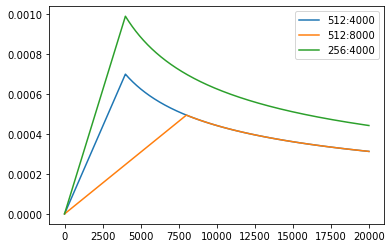

In [23]:
from matplotlib import pyplot as plt

# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [24]:
""" python
预测softmax_res = [0.1, 0.3, 0.6]
真实结果是[2] -->[0,0,1]
如果不做平滑直接是这两者计算交叉信息熵
如果做了平滑可以把真实结果修改为
[0.1,0.1,0.8]
计算他们的kl散度"""
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    """
    size:预测词典长度
    smoothing:分给真实标签，1-smoothing，其余的smoothing/(n-1)
    """
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.long().data.unsqueeze(1), self.confidence)
        #scatter_(dim, index, src):
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))


In [25]:
#计算损失
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        """
        norm 非pad的单词个数
        """
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

In [26]:
import time


#单个训练
def run_epoch(data_iter, model, loss_compute, epoch):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        batch.src = torch.tensor(batch.src).cuda()
        batch.trg = torch.tensor(batch.trg).cuda()
        batch.src_mask = torch.tensor(batch.src_mask).cuda()
        batch.trg_mask = torch.tensor(batch.trg_mask).cuda()
        batch.trg_y = torch.tensor(batch.trg_y).cuda()
        batch.ntokens = torch.tensor(batch.ntokens).cuda()
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (epoch, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [27]:
def train(data, model, criterion, optimizer):
    """
    训练并保存模型
    """
    # 初始化模型在dev集上的最优Loss为一个较大值
    best_dev_loss = 1e5
    model.cuda()
    #data.train_data.cuda()
    #data.dev_data.cuda()
    for epoch in range(EPOCHS):
        # 模型训练
        model.train()
        #run_epoch(data.train_data, model, SimpleLossCompute(model.generator, criterion, optimizer), epoch)
        run_epoch(data.train_data, model, SimpleLossCompute(model.generator, criterion, optimizer), epoch)
        #
        model.eval()

        # 在dev集上进行loss评估
        print('>>>>> Evaluate')
        #dev_loss = run_epoch(data.dev_data, model, SimpleLossCompute(model.generator, criterion, None), epoch)
        dev_loss = run_epoch(data.dev_data, model, SimpleLossCompute(model.generator, criterion, None), epoch)
        print('<<<<< Evaluate loss: %f' % dev_loss)

        # TODO: 如果当前epoch的模型在dev集上的loss优于之前记录的最优loss则保存当前模型，并更新最优loss值
        if dev_loss < best_dev_loss:
            torch.save(model.state_dict(), SAVE_FILE)
            best_dev_loss = dev_loss


In [28]:
# 初始化参数设置


UNK = 0  # 未登录词的标识符对应的词典id
PAD = 1  # padding占位符对应的词典id
BATCH_SIZE = 32  # 每批次训练数据数量
EPOCHS = 30  # 训练轮数
LAYERS = 6  # transformer中堆叠的encoder和decoder block层数
H_NUM = 8  # multihead attention hidden个数
D_MODEL = 256  # embedding维数
D_FF = 2048  # feed forward第一个全连接层维数
DROPOUT = 0.1  # dropout比例
MAX_LENGTH = 40  # 最大句子长度

TRAIN_FILE = './data/training.txt'  # 训练集数据文件
VAIL_FILE = "./data/validation.txt"  # 验证(开发)集数据文件
SAVE_FILE = './save/model.pt'  # 模型保存路径(注意如当前目录无save文件夹需要自己创建)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def seq_padding(X, padding=0):
    """
    对一个batch批次(以单词id表示)的数据进行padding填充对齐长度
    """
    # 计算该批次数据各条数据句子长度
    L = [len(x) for x in X]
    # 获取该批次数据最大句子长度
    ML = max(L)
    # 对X中各条数据x进行遍历，如果长度短于该批次数据最大长度ML，则以padding id填充缺失长度ML-len(x)
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])


In [29]:
from collections import Counter
from nltk import word_tokenize
class PrepareData:
    def __init__(self, train_file, vail_file):
        # 读取数据 并分词
        self.train_en, self.train_cn = self.load_data(train_file)
        self.dev_en, self.dev_cn = self.load_data(vail_file)

        # 构建单词表
        self.en_word_dict, self.en_total_words, self.en_index_dict = self.build_dict(self.train_en)
        self.cn_word_dict, self.cn_total_words, self.cn_index_dict = self.build_dict(self.train_cn)

        # id化
        self.train_en, self.train_cn = self.wordToID(self.train_en, self.train_cn, self.en_word_dict, self.cn_word_dict)
        self.dev_en, self.dev_cn = self.wordToID(self.dev_en, self.dev_cn, self.en_word_dict, self.cn_word_dict)

        # 划分batch + padding + mask
        self.train_data = self.splitBatch(self.train_en, self.train_cn, BATCH_SIZE)
        self.dev_data = self.splitBatch(self.dev_en, self.dev_cn, BATCH_SIZE)

    def load_data(self, path):
        """
        读取翻译前(英文)和翻译后(中文)的数据文件
        每条数据都进行分词，然后构建成包含起始符(BOS)和终止符(EOS)的单词(中文为字符)列表
        形式如：en = [['BOS', 'i', 'love', 'you', 'EOS'], ['BOS', 'me', 'too', 'EOS'], ...]
                cn = [['BOS', '我', '爱', '你', 'EOS'], ['BOS', '我', '也', '是', 'EOS'], ...]
        """
        en = []
        cn = []
        # TODO ...
        with open(path, 'r', encoding='utf-8') as fin:
            
            for line in fin.readlines():
                list_content = line.split('\t')
                # print(list_content)
                en.append(['BOS'] + word_tokenize(list_content[0]) + ['EOS'])
                cn.append(['BOS'] + word_tokenize(" ".join(list_content[1])) + ['EOS'])
                
        return en, cn

    def build_dict(self, sentences, max_words = 50000):
        """
        传入load_data构造的分词后的列表数据
        构建词典(key为单词，value为id值)
        """
        # 对数据中所有单词进行计数
        word_count = Counter()

        for sentence in sentences:
            for s in sentence:
                word_count[s] += 1
        # 只保留最高频的前max_words数的单词构建词典
        # 并添加上UNK和PAD两个单词，对应id已经初始化设置过
        ls = word_count.most_common(max_words)
        # 统计词典的总词数
        total_words = len(ls) + 2

        word_dict = {w[0]: index + 2 for index, w in enumerate(ls)}
        word_dict['UNK'] = UNK
        word_dict['PAD'] = PAD
        # 再构建一个反向的词典，供id转单词使用
        index_dict = {v: k for k, v in word_dict.items()}

        return word_dict, total_words, index_dict

    def wordToID(self, en, cn, en_dict, cn_dict, sort=True):
        """
        该方法可以将翻译前(英文)数据和翻译后(中文)数据的单词列表表示的数据
        均转为id列表表示的数据
        如果sort参数设置为True，则会以翻译前(英文)的句子(单词数)长度排序
        以便后续分batch做padding时，同批次各句子需要padding的长度相近减少padding量
        """
        # 计算英文数据条数
        length = len(en)

        # TODO: 将翻译前(英文)数据和翻译后(中文)数据都转换为id表示的形式
        out_en_ids = [[en_dict.get(w, 0) for w in sent] for sent in en]
        out_cn_ids = [[cn_dict.get(w, 0) for w in sent] for sent in cn]

        # 构建一个按照句子长度排序的函数
        def len_argsort(seq):
            """
            传入一系列句子数据(分好词的列表形式)，
            按照句子长度排序后，返回排序后原来各句子在数据中的索引下标
            """
            return sorted(range(len(seq)), key=lambda x: len(seq[x]))

        # 把中文和英文按照同样的顺序排序
        if sort:
            # 以英文句子长度排序的(句子下标)顺序为基准
            sorted_index = len_argsort(out_en_ids)

            # TODO: 对翻译前(英文)数据和翻译后(中文)数据都按此基准进行排序
            out_en_ids = [out_en_ids[i] for i in sorted_index]
            out_cn_ids = [out_cn_ids[i] for i in sorted_index]

        return out_en_ids, out_cn_ids

    def splitBatch(self, en, cn, batch_size, shuffle=True):
        """
        将以单词id列表表示的翻译前(英文)数据和翻译后(中文)数据
        按照指定的batch_size进行划分
        如果shuffle参数为True，则会对这些batch数据顺序进行随机打乱
        """
        # 在按数据长度生成的各条数据下标列表[0, 1, ..., len(en)-1]中
        # 每隔指定长度(batch_size)取一个下标作为后续生成batch的起始下标
        idx_list = np.arange(0, len(en), batch_size)
        # 如果shuffle参数为True，则将这些各batch起始下标打乱
        if shuffle:
            np.random.shuffle(idx_list)
        # 存放各个batch批次的句子数据索引下标
        batch_indexs = []
        for idx in idx_list:
            # 注意，起始下标最大的那个batch可能会超出数据大小
            # 因此要限定其终止下标不能超过数据大小

            batch_indexs.append(np.arange(idx, min(idx + batch_size, len(en))))

        # 按各batch批次的句子数据索引下标，构建实际的单词id列表表示的各batch句子数据
        batches = []
        for batch_index in batch_indexs:
            # 按当前batch的各句子下标(数组批量索引)提取对应的单词id列表句子表示数据
            batch_en = [en[index] for index in batch_index]
            batch_cn = [cn[index] for index in batch_index]
            # 对当前batch的各个句子都进行padding对齐长度
            # 维度为：batch数量×batch_size×每个batch最大句子长度
            batch_cn = seq_padding(batch_cn)
            batch_en = seq_padding(batch_en)
            # 将当前batch的英文和中文数据添加到存放所有batch数据的列表中
            #
            batches.append(Batch(torch.from_numpy(batch_en), torch.from_numpy(batch_cn)))

        return batches

In [30]:
predata = PrepareData(TRAIN_FILE, VAIL_FILE)
en,cn =predata.load_data(TRAIN_FILE)

In [31]:
print(en[0])
print(cn[0])

['BOS', 'it', "'s", 'none', 'of', 'your', 'concern', '.', 'EOS']
['BOS', '这', '不', '关', '你', '的', '事', '。', 'EOS']


In [32]:
predata.train_en[1000]

[2, 27, 13, 597, 10, 3]

In [33]:
print(predata.en_index_dict.get(27))
print(predata.en_index_dict.get(13))
print(predata.en_index_dict.get(597))
print(predata.en_index_dict.get(10))

was
tom
asleep
?


In [34]:
print("*********")
predata.train_data[10].src[10]

*********


tensor([   2,   52, 1133,   11,    6, 1301,   10,    3], dtype=torch.int32)

In [35]:
print(predata.en_index_dict.get(225))
print(predata.en_index_dict.get(11))
print(predata.en_index_dict.get(248))
print(predata.en_index_dict.get(4))

life
is
beautiful
.


In [36]:
# 数据预处理
data = PrepareData(TRAIN_FILE, VAIL_FILE)
src_vocab = len(data.en_word_dict)
tgt_vocab = len(data.cn_word_dict)
print("src_vocab %d" % src_vocab)
print("tgt_vocab %d" % tgt_vocab)

# 初始化模型
model = make_model(
                    src_vocab,
                    tgt_vocab,
                    LAYERS,
                    D_MODEL,
                    D_FF,
                    H_NUM,
                    DROPOUT
                )

src_vocab 5580
tgt_vocab 2527


C:\Users\laodi\AppData\Local\Temp/ipykernel_8920/3791962198.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


In [37]:
# 训练
print(">>>>>>> start train")
train_start = time.time()
criterion = LabelSmoothing(tgt_vocab, padding_idx = 0, smoothing= 0.0)
optimizer = NoamOpt(D_MODEL, 1, 2000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9,0.98), eps=1e-9))

train(data, model.cuda(), criterion.cuda(), optimizer)
print(f"<<<<<<< finished train, cost {time.time()-train_start:.4f} seconds")

E:\miniconda3\envs\Python38\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


>>>>>>> start train


C:\Users\laodi\AppData\Local\Temp/ipykernel_8920/2948464230.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch.src = torch.tensor(batch.src).cuda()
C:\Users\laodi\AppData\Local\Temp/ipykernel_8920/2948464230.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch.trg = torch.tensor(batch.trg).cuda()
C:\Users\laodi\AppData\Local\Temp/ipykernel_8920/2948464230.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch.src_mask = torch.tensor(batch.src_mask).cuda()
C:\Users\laodi\AppData\Local\Temp/ipykernel_8920/2948464230.py:15:

Epoch Step: 0 Loss: 7.916300 Tokens per Sec: 1112.715698
Epoch Step: 0 Loss: 6.850322 Tokens per Sec: 3765.808105
Epoch Step: 0 Loss: 6.199982 Tokens per Sec: 3649.751953
Epoch Step: 0 Loss: 5.359284 Tokens per Sec: 3730.557861
Epoch Step: 0 Loss: 4.546889 Tokens per Sec: 3597.563965
Epoch Step: 0 Loss: 4.696634 Tokens per Sec: 3499.347168
Epoch Step: 0 Loss: 4.127663 Tokens per Sec: 3584.738525
Epoch Step: 0 Loss: 4.657183 Tokens per Sec: 3716.832275
Epoch Step: 0 Loss: 4.270918 Tokens per Sec: 3574.641113
Epoch Step: 0 Loss: 4.310666 Tokens per Sec: 3531.087646
Epoch Step: 0 Loss: 4.376198 Tokens per Sec: 3624.461914
Epoch Step: 0 Loss: 3.695674 Tokens per Sec: 3621.164307
>>>>> Evaluate
Epoch Step: 0 Loss: 3.806527 Tokens per Sec: 4972.560547
<<<<< Evaluate loss: 3.837944
Epoch Step: 1 Loss: 4.211561 Tokens per Sec: 3801.089355
Epoch Step: 1 Loss: 3.753890 Tokens per Sec: 3723.572266
Epoch Step: 1 Loss: 3.672273 Tokens per Sec: 3608.841797
Epoch Step: 1 Loss: 3.687582 Tokens per Sec

Epoch Step: 10 Loss: 0.547212 Tokens per Sec: 3596.836670
Epoch Step: 10 Loss: 0.923535 Tokens per Sec: 3710.739502
Epoch Step: 10 Loss: 0.845837 Tokens per Sec: 3599.687012
Epoch Step: 10 Loss: 0.823272 Tokens per Sec: 3569.589600
Epoch Step: 10 Loss: 1.357319 Tokens per Sec: 3658.924561
Epoch Step: 10 Loss: 0.577303 Tokens per Sec: 3640.517090
>>>>> Evaluate
Epoch Step: 10 Loss: 0.547276 Tokens per Sec: 5072.104492
<<<<< Evaluate loss: 0.701767
Epoch Step: 11 Loss: 1.246732 Tokens per Sec: 3852.861328
Epoch Step: 11 Loss: 0.755828 Tokens per Sec: 3769.166016
Epoch Step: 11 Loss: 0.768767 Tokens per Sec: 3661.545898
Epoch Step: 11 Loss: 0.840176 Tokens per Sec: 3738.118896
Epoch Step: 11 Loss: 0.554952 Tokens per Sec: 3588.847656
Epoch Step: 11 Loss: 0.838894 Tokens per Sec: 3521.654541
Epoch Step: 11 Loss: 0.454424 Tokens per Sec: 3623.396973
Epoch Step: 11 Loss: 0.820111 Tokens per Sec: 3720.817627
Epoch Step: 11 Loss: 0.768049 Tokens per Sec: 3602.748291
Epoch Step: 11 Loss: 0.7162

Epoch Step: 20 Loss: 0.460608 Tokens per Sec: 3649.641113
Epoch Step: 20 Loss: 0.178993 Tokens per Sec: 3623.052490
>>>>> Evaluate
Epoch Step: 20 Loss: 0.136638 Tokens per Sec: 5012.429199
<<<<< Evaluate loss: 0.170570
Epoch Step: 21 Loss: 0.483931 Tokens per Sec: 3821.250488
Epoch Step: 21 Loss: 0.267406 Tokens per Sec: 3752.152100
Epoch Step: 21 Loss: 0.250503 Tokens per Sec: 3646.004150
Epoch Step: 21 Loss: 0.306363 Tokens per Sec: 3729.448730
Epoch Step: 21 Loss: 0.149371 Tokens per Sec: 3576.106201
Epoch Step: 21 Loss: 0.266933 Tokens per Sec: 3517.546143
Epoch Step: 21 Loss: 0.167823 Tokens per Sec: 3587.124268
Epoch Step: 21 Loss: 0.300337 Tokens per Sec: 3700.859131
Epoch Step: 21 Loss: 0.262505 Tokens per Sec: 3603.251953
Epoch Step: 21 Loss: 0.244440 Tokens per Sec: 3553.473145
Epoch Step: 21 Loss: 0.441986 Tokens per Sec: 3657.662598
Epoch Step: 21 Loss: 0.159592 Tokens per Sec: 3640.478027
>>>>> Evaluate
Epoch Step: 21 Loss: 0.111908 Tokens per Sec: 5017.434570
<<<<< Evalua

In [38]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """
    传入一个训练好的模型，对指定数据进行预测
    """
    # 先用encoder进行encode
    memory = model.encode(src, src_mask)
    # 初始化预测内容为1×1的tensor，填入开始符('BOS')的id，并将type设置为输入数据类型(LongTensor)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    # 遍历输出的长度下标
    for i in range(max_len-1):
        # decode得到隐层表示
        out = model.decode(memory,
                           src_mask,
                           Variable(ys),
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        # 将隐藏表示转为对词典各词的log_softmax概率分布表示
        prob = model.generator(out[:, -1])
        # 获取当前位置最大概率的预测词id
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        # 将当前位置预测的字符id与之前的预测内容拼接起来
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [39]:
def evaluate(data, model):
    """
    在data上用训练好的模型进行预测，打印模型翻译结果
    """
    # 梯度清零
    with torch.no_grad():
        # 在data的英文数据长度上遍历下标
        for i in range(len(data.dev_en)):
            # TODO: 打印待翻译的英文句子
            en_sent = " ".join([data.en_index_dict[w] for w in  data.dev_en[i]])
            print("\n" + en_sent)

            # TODO: 打印对应的中文句子答案
            cn_sent = " ".join([data.cn_index_dict[w] for w in  data.dev_cn[i]])
            print("".join(cn_sent))

            # 将当前以单词id表示的英文句子数据转为tensor，并放如DEVICE中
            src = torch.from_numpy(np.array(data.dev_en[i])).long().to(DEVICE)
            # 增加一维
            src = src.unsqueeze(0)
            # 设置attention mask
            src_mask = (src != 0).unsqueeze(-2)
            # 用训练好的模型进行decode预测
            out = greedy_decode(model, src, src_mask, max_len=MAX_LENGTH, start_symbol=data.cn_word_dict["BOS"])
            # 初始化一个用于存放模型翻译结果句子单词的列表
            translation = []
            # 遍历翻译输出字符的下标（注意：开始符"BOS"的索引0不遍历）
            for j in range(1, out.size(1)):
                # 获取当前下标的输出字符
                sym = data.cn_index_dict[out[0, j].item()]
                # 如果输出字符不为'EOS'终止符，则添加到当前句子的翻译结果列表
                if sym != 'EOS':
                    translation.append(sym)
                # 否则终止遍历
                else:
                    break
            # 打印模型翻译输出的中文句子结果
            print("translation: %s" % " ".join(translation))

In [40]:
# 预测
# 加载模型
model.load_state_dict(torch.load(SAVE_FILE))
# 开始预测
print(">>>>>>> start evaluate")
evaluate_start  = time.time()
evaluate(data, model)
print(f"<<<<<<< finished evaluate, cost {time.time()-evaluate_start:.4f} seconds")

>>>>>>> start evaluate

BOS see above . EOS
BOS 参 见 上 文 。 EOS
translation: 参 见 上 文 。

BOS join us . EOS
BOS 来 加 入 我 们 吧 。 EOS
translation: 来 加 入 我 们 吧 。

BOS she disappeared . EOS
BOS 她 消 失 了 。 EOS
translation: 她 消 失 了 。

BOS wood burns . EOS
BOS 木 材 燃 烧 。 EOS
translation: 木 材 燃 烧 。

BOS we know . EOS
BOS 我 们 知 道 。 EOS
translation: 我 们 知 道 。

BOS tom UNK . EOS
BOS 汤 姆 皱 著 UNK 头 。 EOS
translation: 汤 姆 皱 著 急 。

BOS he is tall . EOS
BOS 他 高 。 EOS
translation: 他 高 。

BOS boil the water . EOS
BOS 把 水 烧 开 。 EOS
translation: 把 水 烧 开 。

BOS call the police ! EOS
BOS 叫 警 察 ！ EOS
translation: 报 警 ！

BOS i began running . EOS
BOS 我 开 始 跑 。 EOS
translation: 我 开 始 跑 。

BOS do n't worry . EOS
BOS 别 担 心 。 EOS
translation: 别 为 担 心 。

BOS take me home . EOS
BOS 带 我 回 家 。 EOS
translation: 带 我 回 家 。

BOS i admire you . EOS
BOS 我 欣 赏 你 。 EOS
translation: 我 欣 赏 你 。

BOS tom loves flowers . EOS
BOS 汤 姆 热 爱 花 UNK 。 EOS
translation: 汤 姆 热 爱 花 。

BOS i am coming . EOS
BOS 我 来 了 。 EOS
translation: 我 来 了 。

BOS 

translation: 我 更 想 继 续 坐 著 。

BOS at last , he came . EOS
BOS 最 终 ， 他 来 了 。 EOS
translation: 最 终 ， 他 来 了 。

BOS the soccer game is tomorrow . EOS
BOS 明 天 有 足 球 比 赛 。 EOS
translation: 明 天 有 足 球 比 赛 。

BOS they have the same habits . EOS
BOS 他 们 有 相 同 的 嗜 好 。 EOS
translation: 他 们 有 相 同 的 嗜 好 。

BOS tom knows mary was here . EOS
BOS 汤 姆 知 道 玛 丽 在 这 里 。 EOS
translation: 汤 姆 知 道 玛 丽 在 这 里 。

BOS tom has a big appetite . EOS
BOS 汤 姆 胃 口 很 大 。 EOS
translation: 汤 姆 胃 口 很 大 。

BOS it 's my birthday soon . EOS
BOS 我 的 生 日 就 快 到 了 。 EOS
translation: 我 的 生 日 就 快 到 了 。

BOS are you coming next week ? EOS
BOS 你 下 周 来 吗 ？ EOS
translation: 你 下 周 来 吗 ？

BOS what 's the weather like ? EOS
BOS 天 气 怎 么 样 ？ EOS
translation: 天 气 怎 么 样 ？

BOS she is about my age . EOS
BOS 她 大 约 跟 我 同 年 纪 。 EOS
translation: 她 大 约 跟 我 同 年 纪 。

BOS do n't let tom die . EOS
BOS 别 让 汤 姆 死 了 。 EOS
translation: 别 让 汤 姆 死 了 。

BOS the soldiers UNK the building . EOS
BOS 士 兵 们 佔 领 了 这 个 建 筑 。 EOS
translation: 士 兵 们 佔 领 了 这 个 建 筑 。

B

translation: 我 会 带 你 看 我 的 房 间 。

BOS she made fun of her husband . EOS
BOS 她 取 笑 了 她 的 丈 夫 。 EOS
translation: 她 取 笑 了 她 的 丈 夫 。

BOS chocolate has more iron than spinach . EOS
BOS 巧 克 力 含 有 比 菠 菜 更 多 的 铁 质 。 EOS
translation: 巧 克 力 含 有 比 菠 菜 更 多 的 铁 质 。

BOS i have something to give you . EOS
BOS 我 有 些 东 西 要 给 你 。 EOS
translation: 我 有 些 东 西 要 给 你 。

BOS tom is n't a good worker . EOS
BOS 汤 姆 不 是 个 好 工 人 。 EOS
translation: 汤 姆 不 是 个 好 工 人 。

BOS please wait till he comes back . EOS
BOS 请 等 到 他 回 来 。 EOS
translation: 请 等 到 他 回 来 。

BOS do you want anything to eat ? EOS
BOS 你 想 要 吃 任 何 东 西 吗 ? EOS
translation: 你 想 要 吃 任 何 东 西 吗 ?

BOS i left earlier than my sister . EOS
BOS 我 比 我 的 妹 妹 早 离 开 。 EOS
translation: 我 比 我 的 妹 妹 早 离 开 。

BOS is everything going ok at work ? EOS
BOS 工 作 一 切 顺 利 吗 ？ EOS
translation: 工 作 一 切 顺 利 吗 ？

BOS we 've already won this battle . EOS
BOS 我 们 已 经 赢 得 了 这 场 战 斗 。 EOS
translation: 我 们 已 经 赢 得 了 这 场 战 斗 。

BOS can i have something to eat ? EOS
BOS 我 能 些 吃 的 东 西 

translation: 他 和 他 的 邻 居 相 处 。

BOS i do n't see much of him . EOS
BOS 我 不 常 见 到 他 。 EOS
translation: 我 不 常 见 到 他 。

BOS she was very proud of her father . EOS
BOS 她 为 她 的 父 亲 感 到 非 常 骄 傲 。 EOS
translation: 她 为 她 的 父 亲 感 到 非 常 骄 傲 。

BOS i would like to be a UNK . EOS
BOS 我 想 要 成 为 吉 他 手 。 EOS
translation: 我 想 要 成 为 吉 他 手 。

BOS my leg was bitten by that dog . EOS
BOS 我 的 腿 被 那 只 狗 咬 了 。 EOS
translation: 我 的 腿 被 那 只 狗 咬 了 。

BOS i 've found a place to live . EOS
BOS 我 找 到 了 个 住 处 。 EOS
translation: 我 找 到 了 个 住 处 。

BOS i think i know who did it . EOS
BOS 我 认 为 我 知 道 是 谁 做 的 。 EOS
translation: 我 认 为 我 知 道 是 谁 做 的 。

BOS i got up early in the morning . EOS
BOS 我 早 上 很 早 起 牀 。 EOS
translation: 我 早 上 很 早 起 牀 。

BOS what did you major in at college ? EOS
BOS 你 大 学 时 主 修 什 么 ？ EOS
translation: 你 大 学 时 主 修 什 么 ？

BOS tom does n't share mary 's UNK . EOS
BOS 汤 姆 没 有 感 受 到 玛 丽 的 热 情 。 EOS
translation: 汤 姆 没 有 感 受 到 玛 丽 的 热 情 。

BOS i 've been careful my whole life . EOS
BOS 我 一 生 都 谨 慎 行 事 。 EO

translation: 随 意 吃 点 蛋 糕 。

BOS i helped my father wash his car . EOS
BOS 我 帮 我 父 亲 洗 他 的 车 。 EOS
translation: 我 帮 我 父 亲 洗 他 的 车 。

BOS the bus stop is near our school . EOS
BOS 巴 士 站 离 我 们 的 学 校 近 。 EOS
translation: 巴 士 站 离 我 们 的 学 校 近 。

BOS i was afraid i would be late . EOS
BOS 我 怕 我 会 迟 到 。 EOS
translation: 我 怕 我 会 迟 到 。

BOS i plan to buy him a pen . EOS
BOS 我 打 算 给 他 买 一 支 钢 笔 。 EOS
translation: 我 打 算 给 他 买 一 支 钢 笔 。

BOS my mother is a very good cook . EOS
BOS 我 妈 妈 的 厨 艺 很 好 。 EOS
translation: 我 妈 妈 是 个 很 棒 的 厨 师 。

BOS she is busy preparing for the trip . EOS
BOS 她 正 忙 著 准 备 这 次 旅 行 。 EOS
translation: 她 正 忙 著 准 备 这 次 旅 游 。

BOS tom is unlikely to do that again . EOS
BOS 汤 姆 不 太 可 能 再 那 么 做 了 。 EOS
translation: 汤 姆 不 太 可 能 再 那 么 做 了 。

BOS the flood caused a lot of damage . EOS
BOS 洪 水 造 成 了 很 大 的 损 害 。 EOS
translation: 洪 水 造 成 了 很 大 的 损 害 。

BOS you do n't need to study today . EOS
BOS 你 今 天 不 必 读 书 。 EOS
translation: 你 今 天 不 必 读 书 。

BOS how many UNK are there in japan ? EOS

translation: 你 在 电 视 上 看 足 球 赛 了 吗 ？

BOS we did n't know what to do next . EOS
BOS 我 们 不 知 道 下 一 步 要 做 什 么 。 EOS
translation: 我 们 不 知 道 下 一 步 要 做 什 么 。

BOS she rested her head on her mother 's shoulder . EOS
BOS 她 把 头 UNK 在 她 母 亲 的 肩 上 。 EOS
translation: 她 把 头 发 的 头 去 了 她 母 亲 的 肩 上 。

BOS i do n't know if i have the time . EOS
BOS 我 不 知 道 我 有 没 有 时 间 。 EOS
translation: 我 不 知 道 我 有 没 有 时 间 。

BOS are you planning on eating that all by yourself ? EOS
BOS 你 打 算 自 己 一 人 把 它 全 部 吃 了 吗 ？ EOS
translation: 你 打 算 自 己 一 人 把 它 全 部 吃 了 吗 ？

BOS i will be absent from home in the afternoon . EOS
BOS 下 午 我 不 在 家 。 EOS
translation: 下 午 我 不 会 呆 在 家 里 。

BOS no , thank you . i 've had enough . EOS
BOS 不 ， 谢 谢 你 。 我 已 经 吃 饱 了 。 EOS
translation: 不 ， 谢 谢 你 。 我 已 经 吃 饱 了 。

BOS without the sun , there would be no life . EOS
BOS 没 有 太 阳 就 没 有 生 命 。 EOS
translation: 没 有 太 阳 就 没 有 生 命 。

BOS she stayed in that area for a short while . EOS
BOS 她 在 那 地 方 待 了 片 刻 。 EOS
translation: 她 在 那 地 方 待 了 片 刻 。

BOS we w

translation: 我 认 为 ， 要 找 到 汤 姆 可 不 容 易 。

BOS we 're out of tissue paper , so i 've got to go buy some . EOS
BOS 卫 生 纸 用 完 了 ， 我 必 须 去 买 。 EOS
translation: 卫 生 纸 用 完 了 ， 我 必 须 去 买 。

BOS if a person has not had a chance to UNK his target language by the time he 's an adult , he 's unlikely to be able to reach native speaker level in that language . EOS
BOS 如 果 一 个 人 在 成 人 前 没 有 机 会 习 得 目 标 语 言 ， 他 对 该 语 言 的 认 识 达 到 母 语 者 程 度 的 机 会 是 相 当 小 的 。 EOS
translation: 如 果 一 个 人 在 成 人 前 没 有 机 会 习 得 目 标 语 言 ， 他 对 该 语 言 的 认 识 达 到 母 语 者 程 度 的 语 言 的
<<<<<<< finished evaluate, cost 177.0160 seconds
